In [ ]:
# Rabbits and foxes

There are initially 400 rabbits and 200 foxes on a farm (but it could be two cell types in a 96 well plate or something, if you prefer bio-engineering analogies). Plot the concentration of foxes and rabbits as a function of time for a period of up to 600 days. The predator-prey relationships are given by the following set of coupled ordinary differential equations:

\begin{align}
\frac{dR}{dt} &= k_1 R - k_2 R F \tag{1}\\
\frac{dF}{dt} &= k_3 R F - k_4 F \tag{2}\\
\end{align}

* Constant for growth of rabbits $k_1 = 0.015$ day<sup>-1</sup>
* Constant for death of rabbits being eaten by foxes $k_2 = 0.00004$ day<sup>-1</sup> foxes<sup>-1</sup>
* Constant for growth of foxes after eating rabbits $k_3 = 0.0004$ day<sup>-1</sup> rabbits<sup>-1</sup>
* Constant for death of foxes $k_1 = 0.04$ day<sup>-1</sup>

Also plot the number of foxes versus the number of rabbits.

Then try also with 
* $k_3 = 0.00004$ day<sup>-1</sup> rabbits<sup>-1</sup>
* $t_{final} = 800$ days

*This problem is based on one from Chapter 1 of H. Scott Fogler's textbook "Essentials of Chemical Reaction Engineering".*


# Solving ODEs

*Much of the following content reused under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth. Partly based on David Ketcheson's pendulum lesson, also under CC-BY. https://github.com/numerical-mooc/numerical-mooc*

Let's step back for a moment. Suppose we have a first-order ODE $u'=f(u)$. You know that if we were to integrate this, there would be an arbitrary constant of integration. To find its value, we do need to know one point on the curve $(t, u)$. When the derivative in the ODE is with respect to time, we call that point the _initial value_ and write something like this:

$$u(t=0)=u_0$$

In the case of a second-order ODE, we already saw how to write it as a system of first-order ODEs, and we would need an initial value for each equation: two conditions are needed to determine our constants of integration. The same applies for higher-order ODEs: if it is of order $n$, we can write it as $n$ first-order equations, and we need $n$ known values. If we have that data, we call the problem an _initial value problem_.

Remember the definition of a derivative? The derivative represents the slope of the tangent at a point of the curve $u=u(t)$, and the definition of the derivative $u'$ for a function is:

$$u'(t) = \lim_{\Delta t\rightarrow 0} \frac{u(t+\Delta t)-u(t)}{\Delta t}$$

If the step $\Delta t$ is already very small, we can _approximate_ the derivative by dropping the limit. We can write:

$$\begin{equation}
u(t+\Delta t) \approx u(t) + u'(t) \Delta t
\end{equation}$$

With this equation, and because we know $u'(t)=f(u)$, if we have an initial value, we can step by $\Delta t$ and find the value of $u(t+\Delta t)$, then we can take this value, and find $u(t+2\Delta t)$, and so on: we say that we _step in time_, numerically finding the solution $u(t)$ for a range of values: $t_1, t_2, t_3 \cdots$, each separated by $\Delta t$. The numerical solution of the ODE is simply the table of values $t_i, u_i$ that results from this process.


# Euler's method
*Also known as "Simple Euler" or sometimes "Simple Error".*

The approximate solution at time $t_n$ is $u_n$, and the numerical solution of the differential equation consists of computing a sequence of approximate solutions by the following formula, based on Equation (10):

$$u_{n+1} = u_n + \Delta t \,f(u_n).$$

This formula is called **Euler's method**.

For the equations of the rabbits and foxes, Euler's method gives the following algorithm that we need to implement in code:

\begin{align}
R_{n+1} & = R_n + \Delta t \left(k_1 R_n - k_2 R_n F_n \right) \\
F_{n+1} & = F_n + \Delta t \left( k_3 R_n F-n - k_4 F_n \right).
\end{align}


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [2]:
#This is a comment, I will figure out what I'm doing eventually#

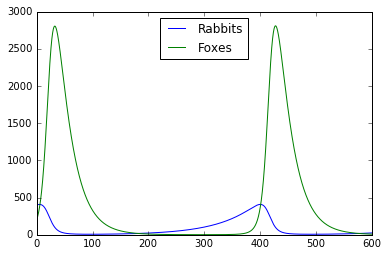

In [3]:
k_1 = 0.015 #day-1
k_2 = 0.00004 #day-1 foxes-1
k_3 = 0.0004 #day-1 rabbit-1
k_4 = 0.04 #day-1

#Euler's Method

t_f = 600 # days
R_0 = 400 # initial number of rabbits
F_0 = 200 # initial number of foxes

#R_{n+1}=R_n+\Delta t(k_1 R_n - k_2 R_n F_n)
#F_{n+1}=F_n+\Delta t(k_3 R_n F_n - k_4 F_n)

Delta_t = 0.01

R = np.empty(int(t_f//Delta_t))
F = np.empty(int(t_f//Delta_t))
t = np.linspace(0,t_f,num = int(t_f//Delta_t))

R[0] = R_0
F[0] = F_0

i=0
while t[i] < t_f:
    R[i+1] = R[i] + Delta_t*(k_1*R[i] - k_2*R[i]*F[i])
    F[i+1] = F[i] + Delta_t*(k_3*R[i]*F[i] - k_4*F[i])
    i += 1


plt.plot(t, R, label = 'Rabbits')
plt.plot(t, F, label = 'Foxes')
plt.legend(loc = 9)

plt.show()

In [ ]:
#Kinetic Monte Carlo to be implemented when Iástin